In [32]:
import boto3
from boto3.dynamodb.conditions import Key
import json
import decimal
import matplotlib.pyplot as plt
from quant import scaling
import pickle
from sklearn.neural_network import MLPRegressor
import numpy as np
import pandas as pd

In [27]:
class DecimalEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, decimal.Decimal):
            return str(o)
        return super(DecimalEncoder, self).default(o)


In [76]:
inst = "CL"
tbl = "margin"
dynamodb = boto3.resource('dynamodb', region_name='us-east-1',
                          endpoint_url="https://dynamodb.us-east-1.amazonaws.com")
table = dynamodb.Table(tbl)
j = table.query(KeyConditionExpression=Key("inst").eq(inst)) 

frames = []
for i in j["Items"]:
    df = json.dumps(i["data"], cls=DecimalEncoder)
    frames.append(pd.read_json(df, orient="records"))
#df = pd.concat(frames)
df = frames[0]


In [77]:
df = df[df["days"] < 1000]
df["num_side"] = np.where(df["side"] == "P", -1, 1)

df["Mny"] = df["num_side"] * np.log(df["ulPrice"] / df["strike"])
df["Diff"] = df["num_side"] * (df["strike"] - df["ulPrice"])


In [78]:
df["Days scaled"] = df["days"] / 365
df["SI Scaled"] = scaling.scale11(df["marginShort"])
df["LI Scaled"] = scaling.scale11(df["marginLong"])
df = df.dropna()


In [79]:
x_train = df[["Mny", "Days scaled", "delta"]].as_matrix()
y_train_l = df["LI Scaled"].as_matrix()
y_train_s = df["SI Scaled"].as_matrix()


In [80]:
nnet_si = MLPRegressor(hidden_layer_sizes=(20, 20, 10),
                       learning_rate_init=0.05,
                       max_iter=500,
                       solver="lbfgs",
                       activation="tanh")
nnet_li = MLPRegressor(hidden_layer_sizes=(20, 20, 10),
                       learning_rate_init=0.05,
                       max_iter=500,
                       solver="lbfgs",
                       activation="tanh")
res_s = nnet_si.fit(x_train, y_train_s)
res_l = nnet_li.fit(x_train, y_train_l)


In [81]:
y_pred_l = nnet_li.predict(x_train)
y_pred_s = nnet_si.predict(x_train)

In [66]:
s3 = "sigma.bucket"
limits = {"short_min": min(df["marginShort"]),
          "short_max": max(df["marginShort"]),
          "long_min": min(df["marginLong"]),
          "long_max": max(df["marginLong"])}
fit = {"limits": limits,
       "long": nnet_si,
       "short": nnet_li}

b = boto3.resource('s3')
o = b.Object(s3, 'fit.data')
response = o.put(Body=pickle.dumps(fit))


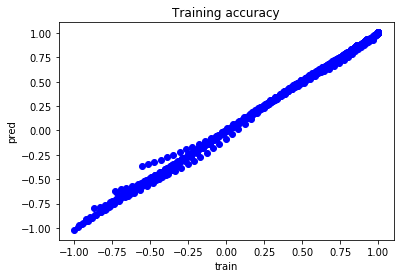

In [82]:
%matplotlib inline
plt.figure()
plt.plot(y_train_s, y_pred_s, "bo")
plt.xlabel("train")
plt.ylabel("pred")
plt.title("Training accuracy")
plt.show()


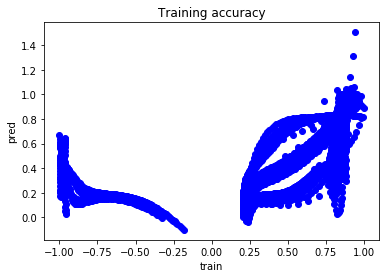

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(y_train_l, y_pred_l, "bo")
plt.xlabel("train")
plt.ylabel("pred")
plt.title("Training accuracy")
plt.show()
